##### Copyright 2019-2021 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Generative Modeling of Galaxy Images

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)
This adaptation comes from the python notebook available in 
https://github.com/EiffL/Tutorials/blob/master/GenerativeModels/GalaxyMorphologyVAE_solution.ipynb

### Overview

This tutorial aims to migrate the information corresponding to the model used in the article "Deep Generative Models for Galaxy Image Simulations" designed in TensorFlow 1.x to a more modern framework such as JAX.

In [1]:
from jax.lib import xla_bridge

#Checking for GPU access
print('Device: {}'.format(xla_bridge.get_backend().platform))

Device: gpu


In [2]:
import jax

# Checking the GPU available
gpus = jax.devices('gpu')
print(len(gpus))

3


## Importing the dataset

First of all, we need to read the data.

In [3]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds
import hsc_photoz

# Loading the dataset and transforming it to NumPy Arrays
train_dset, info = tfds.load(name="hsc_photoz", batch_size=-1, with_info=True, split='train')
train_dset = tfds.as_numpy(train_dset)

2023-05-16 16:55:25.822645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/local/home/jt275011/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# What's in our dataset:
info;

Ok, we see that this dataset is a dictionary, field inputs are hsc cutouts in 5 bands (g,r,i,z,y), this will be the inputs to our CNN. We also see a specz_redshift entry, that will be our prediction target. Let's have a look at these.


In [5]:
# train_dset['image'].shape[0]
len(train_dset['image'][:25,:,:,:])

25

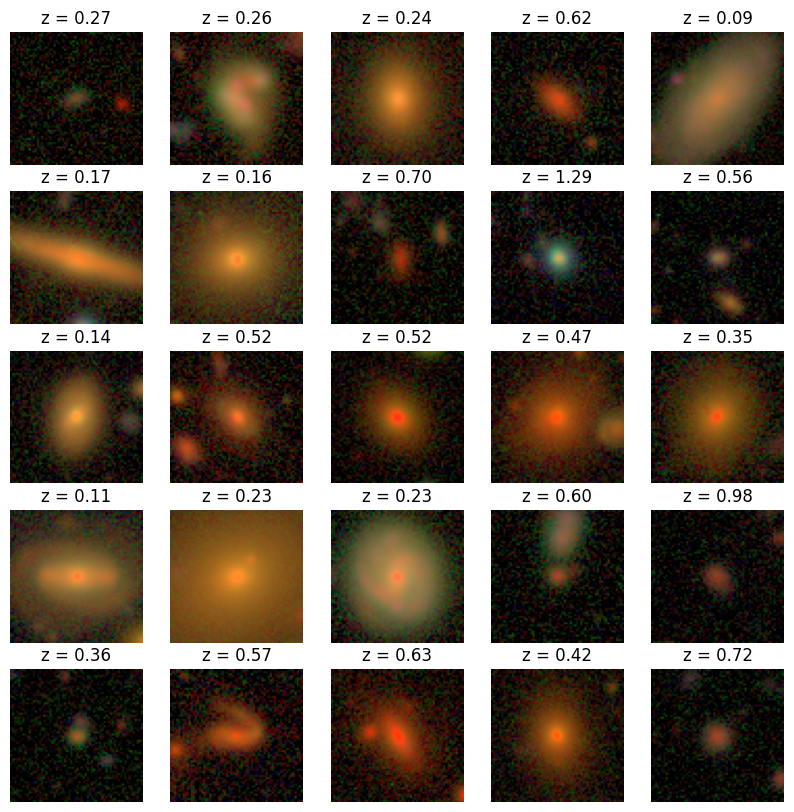

In [6]:
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# The data is in 5 bands GRIZY, but for visualisation we use only the
# 3 first bands and luptonize them
def luptonize(img):
  return make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0],
                         Q=15, stretch=0.5, minimum=0)

plt.figure(figsize=(10,10))
for i, entry in enumerate(train_dset['image'][:25,:,:,:]):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(entry))
  plt.title('z = {:.2f}'.format(train_dset['attrs']['specz_redshift'][i]))
  plt.axis('off')

Checking the distribution of the pixel values

In [7]:
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(train_dset['image'][:1000,:,:,:]):
  specz.append(train_dset['attrs']['specz_redshift'][batch])
  cutouts.append(train_dset['image'][batch])

cutouts = np.stack(cutouts)
specz = np.stack(specz)

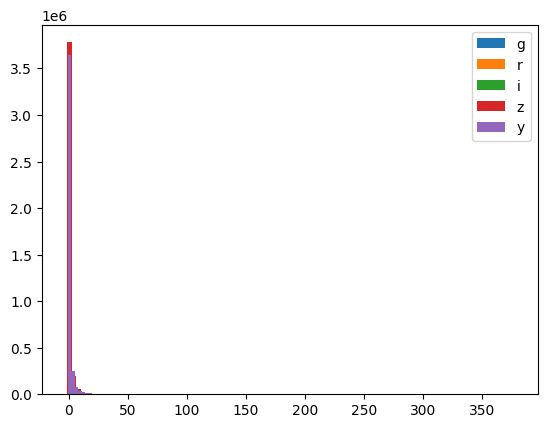

In [8]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b);
plt.legend();

As we can observe the pixel values are not standarized. In fact, they don't seem to follow a normal distribution. In order to facilitate data processing in the neural network, a good idea is to standardize the data.

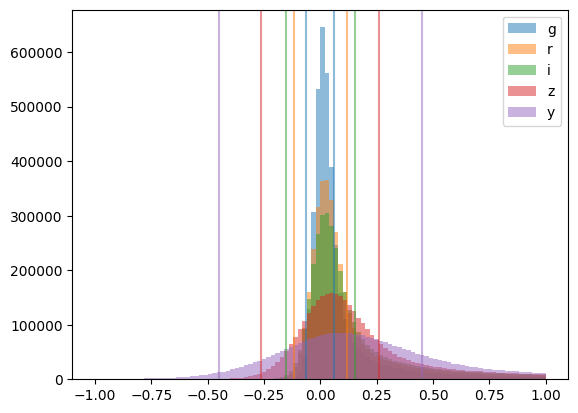

In [9]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5,range=[-1,1]);
  sigma = mad_std(cutouts[...,i]) # Capturing the std devation of each band
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend();

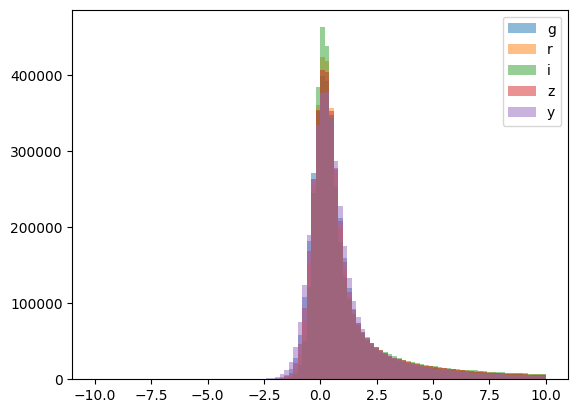

In [10]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
plt.legend();

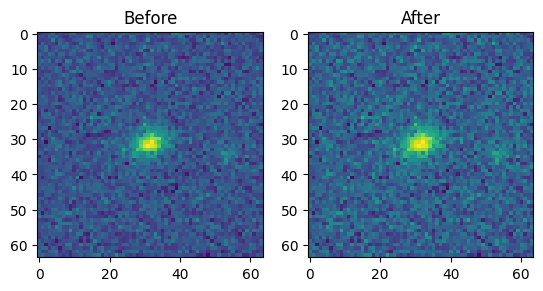

In [11]:
# we can have a look at individual postage stamps with or without this scaling
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cutouts[0,:,:,1]/scaling[1])
ax1.set_title('Before')
ax2.imshow(np.arcsinh(cutouts[0,:,:,1]/scaling[1]/3))
ax2.set_title('After');

Now that we have defined a scaling for the data that should be appropriate, we can build a scaling function and apply it to the dataset:

### Create the input pipeline

Now that we know how to preprocess the data, we can build the input pipeline. Below is a function that creates a Dataset object from the tfrecords files, decode them, applies preprocessing, shuffles the dataset, and create batches of data. Finally the function returns the dataset, that Flax models can directly ingest.

In [12]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
    img = tf.math.asinh(example['image'] / tf.constant(scaling) / 3. )
    # We return the image as our input and output for a generative model
    return img, img

def input_fn(mode='train', batch_size=64):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load('hsc_photoz', split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load('hsc_photoz', split='train[80%:]')
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset

In [13]:
dset = input_fn().as_numpy_iterator()

In [14]:
next(dset)[0].shape

(64, 64, 64, 5)

In [15]:
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from flax import linen as nn  # Linen API
from jax import random
from typing import Optional

tfd = tfp.distributions
tfb = tfp.bijectors

class probabilistic_encoder(nn.Module):
    """Creates a small convolutional encoder for the requested latent dimension."""
    latent_dim : int = 32
    
    @nn.compact
    def __call__(self, x):
    
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 32x32x32
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 16x16x64
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 8x8x128
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 4x4x256
        x = x.reshape((x.shape[0], -1))  # flatten
        # Densifying the network to arrive to the latent space
        x = nn.Dense(features=128)(x)
        x = nn.leaky_relu(x)
        
        return x

Testing the sizes of each layer of the CNN 

In [16]:
cnn = probabilistic_encoder()
print(cnn.tabulate(random.PRNGKey(0), jnp.ones((1, 64, 64, 5))))


                         probabilistic_encoder Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module         ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ probabilistic… │ float32[1,64,… │ float32[1,128]  │                │
├─────────┼────────────────┼────────────────┼─────────────────┼────────────────┤
│ Conv_0  │ Conv           │ float32[1,64,… │ float32[1,32,3… │ bias:          │
│         │                │                │                 │ float32[32]    │
│         │                │                │                 │ kernel:        │
│         │                │                │                 │ float32[3,3,5… │
│         │                │                │                 │                │
│         │                │                │                 │ 1,472 (5.9 KB) │
├─────────┼────────────────

Consruction of the VAE architecture

In [17]:
from absl import app
from absl import flags

# FLAGS = flags.FLAGS

# flags.DEFINE_float(
#     'learning_rate', default=1e-3,
#     help=('The learning rate for the Adam optimizer.')
# )

# flags.DEFINE_integer(
#     'batch_size', default=64,
#     help=('Batch size for training.')
# )

# flags.DEFINE_integer(
#     'num_epochs', default=15,
#     help=('Number of training epochs.')
# )

# flags.DEFINE_integer(
#     'latent_dim', default=32,
#     help=('Dimension of latent space.')
# )

class probabilistic_encoder(nn.Module):
    """Creates a small convolutional encoder for the requested latent dimension."""
    latent_dim : int = 32
    
    # We choose a prior distribution for the latent codes
    # prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(latent_dim))

    @nn.compact
    def __call__(self, x):
        # First convolution layer
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 32x32x32
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 16x16x64
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 8x8x128
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 4x4x256
        # x = x.reshape((x.shape
        x = x.reshape((x.shape[0],-1)) # flatten
        # x = x.reshape((1, x.shape[0], -1))  # flatten 2nd time
        # Densifying the network to arrive to the latent space
        x = nn.Dense(features=128)(x)
        x = nn.leaky_relu(x)
        net = nn.Dense(features=self.latent_dim*2)(x)
        q = tfd.MultivariateNormalDiag(loc=net[:, :self.latent_dim], 
                               scale_diag=net[:, self.latent_dim:])
        return q

class probabilistic_decoder(nn.Module):
    """Creates a small convolutional decoder for the requested latent dimension."""
    latent_dim : int = 32
    
    @nn.compact
    def __call__(self, z):
        
        # Defining the batch size
        batch_size = z.shape[0]
        # Dense layer with the right size
        z = nn.Dense(features=4*4*256)(z)
        z = nn.leaky_relu(z)
        # Reshaping the layer
        z = z.reshape((batch_size, 4, 4, 256))
        # Image is now 4x4x256
        z = nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 8x8x128
        z = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 16x16x64
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 32x32x32
        z = nn.ConvTranspose(features=5, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.activation.softplus(z)
        # Image is now 64x64x5
        r =tfd.MultivariateNormalDiag(loc=z,
                                      scale_diag=[0.01, 0.01, 0.01, 0.01, 0.01])

        return r
    
class VAE(nn.Module):
    latent_dim : int = 32

    def setup(self):
        self.probabilistic_encoder = probabilistic_encoder(self.latent_dim)
        self.probabilistic_decoder = probabilistic_decoder()
        
    def __call__(self, x):
        z = self.probabilistic_encoder(x)
        recon_x = self.probabilistic_decoder(z)
        return recon_x
    
# @jax.vmap
# def model():
#     return VAE(latent_dim=FLAGS.latent_dim)

In [18]:
tfd.MultivariateNormalDiag(jnp.ones(4)).parameters

{'loc': Array([1., 1., 1., 1.], dtype=float32),
 'scale_diag': None,
 'validate_args': False,
 'allow_nan_stats': True,
 'experimental_use_kahan_sum': False,
 'name': 'MultivariateNormalDiag'}

Validating that the encoder works properly

In [19]:
# Let's instantiate the encoder
cnn = probabilistic_encoder()
# Initial parameters 
params_enc = cnn.init(random.PRNGKey(0), jnp.ones((3, 64, 64, 5)))

In [20]:
# Checking for the sizes of each layer

dict_cnn = params_enc._dict['params'].items()
for key, value in dict_cnn:
    for param in value.keys():
        print(key, param,':' , value[param].shape)

Conv_0 kernel : (3, 3, 5, 32)
Conv_0 bias : (32,)
Conv_1 kernel : (3, 3, 32, 64)
Conv_1 bias : (64,)
Conv_2 kernel : (3, 3, 64, 128)
Conv_2 bias : (128,)
Conv_3 kernel : (3, 3, 128, 256)
Conv_3 bias : (256,)
Dense_0 kernel : (4096, 128)
Dense_0 bias : (128,)
Dense_1 kernel : (128, 64)
Dense_1 bias : (64,)


In [21]:
#Veryfing the output
a = cnn.apply(params_enc, jnp.ones((3, 64, 64, 5)))
a

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[32] dtype=float32>

In [22]:
# Let's instantiate the decoder
cnn_2 = probabilistic_decoder()
# Initial parameters 
params_dec = cnn_2.init(random.PRNGKey(0), jnp.ones((1, 32)))

In [23]:
# Checking for the sizes of each layer

dict_cnn = params_dec._dict['params'].items()
for key, value in dict_cnn:
    for param in value.keys():
        print(key, param,':' , value[param].shape)

Dense_0 kernel : (32, 4096)
Dense_0 bias : (4096,)
ConvTranspose_0 kernel : (3, 3, 256, 128)
ConvTranspose_0 bias : (128,)
ConvTranspose_1 kernel : (3, 3, 128, 64)
ConvTranspose_1 bias : (64,)
ConvTranspose_2 kernel : (3, 3, 64, 32)
ConvTranspose_2 bias : (32,)
ConvTranspose_3 kernel : (3, 3, 32, 5)
ConvTranspose_3 bias : (5,)


In [24]:
#Veryfing the output
b = cnn_2.apply(params_dec, jnp.ones((1, 32)))
b

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[1, 64, 64] event_shape=[5] dtype=float32>

In [25]:
# Let's instantiate the decoder
# cnn_2 = probabilistic_decoder(a)
# Initial parameters 
# params = cnn_2.init(a)

In [26]:
# cnn_2

In [27]:
batch_im = next(dset)[0]

In [28]:
batch_im.shape

(64, 64, 64, 5)

In [29]:
batch_encoded = cnn.apply(params_enc, batch_im)    # Apply the encoder on images 

In [30]:
batch_encoded

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[64] event_shape=[32] dtype=float32>

In [31]:
cnn_2 = probabilistic_decoder()

# # Draw a radom sample of the code
code_sample = batch_encoded.sample(seed=random.PRNGKey(0))
# # And decode that sample

variables = cnn_2.init(random.PRNGKey(0), jnp.ones((1,32)))

decoded_im = cnn_2.apply(variables, code_sample)

Some failed tests... (TO comment with Benjamin and Francois)

In [32]:
decoded_im

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[64, 64, 64] event_shape=[5] dtype=float32>

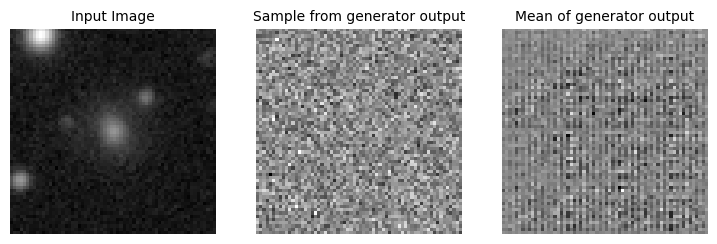

In [33]:
# we can have a look at individual postage stamps with or without this scaling
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
ax1.imshow(batch_im[0,:,:,0],cmap='gray')
ax1.set_title('Input Image', fontsize=10)
ax1.axis('off')
ax2.imshow(decoded_im.sample(seed=random.PRNGKey(24))[0,:,:,0],cmap='gray')
ax2.set_title('Sample from generator output', fontsize=10)
ax2.axis('off')
ax3.imshow(decoded_im.mean()[0,:,:,0],cmap='gray')
ax3.set_title('Mean of generator output', fontsize=10)
ax3.axis('off');